In [1]:
# ライブラリ読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pronto
import copy
import networkx as nx
import os
import pickle
import glob
import gzip
from tqdm.notebook import tqdm
import itertools
#from collections import OrderedDict
#import collections
#from collections import Counter

In [ ]:
path_1 = "/home/admin_user/デスクトップ/UMLS2021AB"
os.chdir(path_1)

In [2]:
#使用するデータ

#hp.oboの最新版
#file_1 : pronto.Ontology.from_obo_library("hp.obo")

#hpoのアノテーションファイル　https://hpo.jax.org/app/download/annotation
file_2 = "phenotype.hpoa" 

 #CTDデータ　http://ctdbase.org/downloads/;jsessionid=7600406AF2DF2A88705D224826A23519
file_3 = "CTD_diseases.tsv.gz"

#UMLSからダウンロード
#https://www.nlm.nih.gov/research/umls/licensedcontent/umlsknowledgesources.html
file_4 = "MRFILES.RRF.gz" #含まれるファイル情報
file_5 = "MRSTY.RRF.gz" #[CUI-セマンティックタイプ] の対応付け

#file_6 = "MRCONSO.RRF.aa.gz" #今回は不要、Zhouらはセマンティックネットワークの再構築で使用
#file_7 = "MRCONSO.RRF.ab.gz" #今回は不要、Zhouらはセマンティックネットワークの再構築で使用
#file_8 = "SRFIL" #今回は不要、Zhouらはセマンティックネットワークの再構築で使用


In [3]:
#symptom
#HPOオントロジーのうちCUIに紐づけられるHPOタームがある。
#UMLSのセマンティックタイプT184（症状）に紐づけられたCUIに関連付けがされたHPOタームだけを使う

In [4]:
#HPOオントロジー

#'hp.obo'読み込み
#最新のタームを取り出す 20220419時点のhp.obo
ont = pronto.Ontology.from_obo_library("hp.obo")

#保存
with open("hp.obo", "wb") as f: 
    ont.dump(f, format="obo")
len(ont)

/home/admin_user/anaconda3/lib/python3.8/site-packages/pronto/ontology.py:206: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  return cls(


16908

In [5]:
#HPOオントロジー中でXREFにUMLSを持つもの
#UMLSへのマッピングの数

hp=[]
umls = []
hp_umls=[]
hp_cui = []

for term in ont.terms():
    for each_xref in term.xrefs:
        if ("Xref('UMLS:" in str(each_xref)):
            cui = str(each_xref).replace("Xref('UMLS:", "").replace("')", "")
            hp.append(term.id) #HPO_id
            umls.append( cui) #CUI
            hp_umls.append([term.id, cui]) #HPO_id, CUI
            hp_cui.append([term.name + '(' + term.id + ')', term.id, cui]) #HPO_id, HPO_name, CUI
                
hp = sorted(list(set(hp)))
umls = sorted(list(set(umls)))
hp_umls = sorted(list(map(list, set(map(tuple, hp_umls)))))
hp_cui = sorted(list(map(list, set(map(tuple, hp_cui)))))

print("HPの数:", len(hp), "CUIの数:", len(umls), "マッピングの数:", len(hp_umls) ,len(hp_cui) )


HPの数: 11589 CUIの数: 12859 マッピングの数: 13005 13005


In [6]:
#'phenotype.hpoa'読み込み
print(file_2)
phenotype_df = pd.read_csv(file_2, header=4, sep="\t", engine="python")

#列名#DatabaseIDを OMIM に絞る
phenotype_df = phenotype_df[phenotype_df["#DatabaseID"].str.contains("OMIM")]
phenotype_df = phenotype_df.rename(columns={'#DatabaseID': "OMIM", "HPO_ID":"HP"})
phenotype_df = phenotype_df[["HP", "OMIM"]]
print("hpoaのアノテーション総数:", len(phenotype_df))
print("hpoaのOMIMの種類数:", phenotype_df["OMIM"].nunique())
print("hpoaのHPOの種類数:", phenotype_df["HP"].nunique())

phenotype.hpoa
hpoaのアノテーション総数: 120331
hpoaのOMIMの種類数: 8120
hpoaのHPOの種類数: 8041


In [7]:
phenotype_df[:3]

,HP,OMIM
0,HP:0000510,OMIM:400004
1,HP:0004325,OMIM:614856
2,HP:0000365,OMIM:614856


In [8]:
#phenotype.hpoaにあるHPOのCUIマッピング

#XREFにUMLSを持つHPO
hp_df = pd.DataFrame(hp, columns=["HP"]) 

#phenotype_dfと合わせる
print("phenotype.hpoaにあるHPOからのCUIマッピング:", len(pd.merge(phenotype_df, hp_df)))
print("そのHPOの数:", pd.merge(phenotype_df, hp_df)["HP"].nunique())
print("そのOMIMの数:", pd.merge(phenotype_df, hp_df)["OMIM"].nunique())

phenotype.hpoaにあるHPOからのCUIマッピング: 117916
そのHPOの数: 7115
そのOMIMの数: 8120


In [9]:
#セマンティックタイプから,T184-CUI-HPOを調査

print(file_4)
mrfiles = pd.read_csv(file_4, sep="\|", header=None, engine="python")
mrfiles.columns=["FIL", "DES", "FMT", "CLS", "RWS" ,"BTS", 0]
mrfiles = mrfiles.iloc[:,:-1]

#FILがファイル名, FMTが列名
mrfiles["FMT_split"] = mrfiles ["FMT"].str.split(",")

MRFILES.RRF.gz


In [10]:
mrfiles[:3]

,FIL,DES,FMT,CLS,RWS,BTS,FMT_split
0,AMBIGLUI.RRF,Ambiguous term identifiers,"LUI,CUI",2,378168,7262285,"[LUI, CUI]"
1,AMBIGSUI.RRF,Ambiguous string identifiers,"SUI,CUI",2,280926,5419566,"[SUI, CUI]"
2,CHANGE/DELETEDCUI.RRF,Deleted concepts,"PCUI,PSTR",2,11747,644911,"[PCUI, PSTR]"


In [11]:
#列名取得
conso_col = mrfiles[mrfiles ["FIL"] =="MRCONSO.RRF"]["FMT_split"].values.tolist()[0] #2MRCONSO.RRF の列名
mrsty_col = mrfiles[mrfiles ["FIL"] =="MRSTY.RRF"]["FMT_split"].values.tolist()[0] #3"MRSTY.RRF"の列名
print(len(conso_col), conso_col)
print(len(mrsty_col), mrsty_col)

18 ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE', 'STR', 'SRL', 'SUPPRESS', 'CVF']
6 ['CUI', 'TUI', 'STN', 'STY', 'ATUI', 'CVF']


In [12]:
#3 MRSTY.RRF 	Semantic Types セマンティックタイプ

print(file_5)
mrsty_org = pd.read_csv(file_5, sep="\|", header=None, engine="python")
mrsty_org.columns = mrsty_col + [0]
mrsty_org = mrsty_org.iloc[:,:len(mrsty_col)]
#データがあるのはCUI, TUI列のみだったので２列だけに絞る
mrsty_org = mrsty_org[["CUI", "TUI"]]
print(len(mrsty_org))

MRSTY.RRF.gz
4864162


In [13]:
mrsty_org[:3]

,CUI,TUI
0,C0000005,T116
1,C0000005,T121
2,C0000005,T130


In [14]:
#T184を持つCUI
t184_cui = mrsty_org[ mrsty_org["TUI"] == "T184"]["CUI"].values.tolist()
print("mrsty.rrf のうち T184_CUI:", len(t184_cui))

#UMLSのT184に紐づけられたCUI。HPOオントロジーではHPOとCUIが紐づけられているので、CUIを使ってT184とHPOがマッピングできる
#HPO_CUIのペアのうち、T184_CUIとペアになっているHPOを取り出す
t184_hp = sorted(list(set([ i[0] for i in hp_umls  if i[1] in t184_cui])))
print("T184_CUI 紐づけられるHPO:", len(t184_hp))

#subsetのHPOのうち T184にあたるHPOの件数
print("phenotype_dfのHPOのうち T184にあたるHPOの件数:", len(set(phenotype_df["HP"].values.tolist()) & set(t184_hp)))

mrsty.rrf のうち T184_CUI: 14281
T184_CUI 紐づけられるHPO: 216
phenotype_dfのHPOのうち T184にあたるHPOの件数: 176


In [15]:
#アノテーションデータをT184_HPOで絞り込む
t184_index = [enu for enu, i in enumerate(phenotype_df["HP"])  if i in t184_hp]
phenotype_df_t184= phenotype_df.iloc[t184_index].reset_index(drop=True)
print(len(phenotype_df_t184), "HP:", phenotype_df_t184["HP"].nunique(), "OMIM:", phenotype_df_t184["OMIM"].nunique())
#7238 HP: 176 OMIM: 3509

7238 HP: 176 OMIM: 3509


In [16]:
#disease
#CTDでMESHと対応付けされたOMIM このOMIMだけを使う


In [17]:
#CTD

print(file_3) 
all_ctd_df = pd.read_csv(file_3, sep='\t', header=27)
all_ctd_df = all_ctd_df[1:]
print("CTDレコード件数:", len(all_ctd_df))

CTD_diseases.tsv.gz
CTDレコード件数: 13144


In [18]:
all_ctd_df[:3]#"使う列は"DiseaseID", "AltDiseaseIDs"

,# DiseaseName,DiseaseID,AltDiseaseIDs,Definition,ParentIDs,TreeNumbers,ParentTreeNumbers,Synonyms,SlimMappings
1,10p Deletion Syndrome (Partial),MESH:C538288,NaN,NaN,MESH:D002872|MESH:D025063,C16.131.260/C538288|C16.320.180/C538288|C23.55...,C16.131.260|C16.320.180|C23.550.210.050.500.500,"Chromosome 10, 10p- Partial|Chromosome 10, mon...",Congenital abnormality|Genetic disease (inborn...
2,13q deletion syndrome,MESH:C535484,NaN,NaN,MESH:D002872|MESH:D025063,C16.131.260/C535484|C16.320.180/C535484|C23.55...,C16.131.260|C16.320.180|C23.550.210.050.500.500,Chromosome 13q deletion|Chromosome 13q deletio...,Congenital abnormality|Genetic disease (inborn...
3,15q24 Microdeletion,MESH:C579849,DO:DOID:0060395,NaN,MESH:D002872|MESH:D008607|MESH:D025063,C10.597.606.360/C579849|C16.131.260/C579849|C1...,C10.597.606.360|C16.131.260|C16.320.180|C23.55...,15q24 Deletion|15q24 Microdeletion Syndrome|In...,Congenital abnormality|Genetic disease (inborn...


In [19]:
ctd_df = all_ctd_df[["DiseaseID", "AltDiseaseIDs"]] #列を限定（→重複データなし）

#AltDiseaseIDsを持つものに限定
ctd = ctd_df[ctd_df["AltDiseaseIDs"].notna()]
ctd = ctd.reset_index(drop=True)
print("AltDiseaseIDsを持つレコード件数:", len(ctd))


AltDiseaseIDsを持つレコード件数: 6595


In [20]:
#DiseaseID=MESH:D
print(len(set([i for i in all_ctd_df["DiseaseID"].unique().tolist() if "MESH:D" in i])))


5022


In [21]:
# 「DiseaseID, AltDiseaseIDs 」が「MESH：D、OMIM」もしくは「OMIM、MESH：D」
#を持つものを探しインデックス番号を取得

#（MESH：D＝Descriptor）
m_o_map_index = [ enu for enu, i in enumerate(ctd.values.tolist()) if (("MESH:D" in i[0]) & ("OMIM" in i[1])) | (("OMIM" in i[0]) & ("MESH:D" in i[1]))]

#インデックス番号でctdをサイズダウン
m_o_map = ctd.iloc[m_o_map_index]
m_o_map = m_o_map.reset_index(drop=True)
print(len(m_o_map))

#AltDiseaseIDs列のデータを要素に分割
m_o_map["AltDiseaseIDs"] = m_o_map["AltDiseaseIDs"].str.split("|")

633


In [22]:
m_o_map[:3]

,DiseaseID,AltDiseaseIDs
0,MESH:D000012,"[DO:DOID:1386, OMIM:200100]"
1,MESH:D020642,"[DO:DOID:2582, OMIM:614097]"
2,MESH:D000130,"[DO:DOID:0111158, DO:DOID:4480, OMIM:100800, O..."


In [23]:
#DiseaseID(MESH)：AltDiseaseIDs(他)＝１：n なので
#DiseaseID(MESH)：AltDiseaseIDs(OMIM)=１：１にする

each_m_o_map = [ [m_o[0], each_id] for m_o in m_o_map.values.tolist() for each_id in m_o[1] if "OMIM" in each_id ]
ctd = pd.DataFrame(each_m_o_map, columns=["MESH", "OMIM"])

print("CTD")
print("MeSH-OMIMマッピングの数:", len(ctd))
print("MESHの数:", len(ctd["MESH"].unique()))
print("OMIMの数:", len(ctd["OMIM"].unique()))


CTD
MeSH-OMIMマッピングの数: 1154
MESHの数: 633
OMIMの数: 1154


In [24]:
print(phenotype_df_t184["OMIM"].nunique(), ctd["OMIM"].nunique(), "\n")
print("phenotype_df_t184:", "\n", phenotype_df_t184[:3], "\n", "ctd:", "\n", ctd[:3])

3509 1154 

phenotype_df_t184: 
            HP         OMIM
0  HP:0001257  OMIM:615685
1  HP:0002020  OMIM:613623
2  HP:0003324  OMIM:154020 
 ctd: 
            MESH         OMIM
0  MESH:D000012  OMIM:200100
1  MESH:D020642  OMIM:614097
2  MESH:D000130  OMIM:100800


In [25]:
#アノテーションデータを症状タームで限定した（T184にあたるHPOのみ）
#さらに疾患タームで限定する（MESHに置換できるOMIMのみ）

subset = pd.merge(phenotype_df_t184, ctd)
print(len(subset))
[ [i, subset[i].nunique()] for i in subset.columns]


1126


[['HP', 137], ['OMIM', 468], ['MESH', 317]]

In [26]:
subset[:3]

,HP,OMIM,MESH
0,HP:0008070,OMIM:600628,MESH:D058247
1,HP:0001250,OMIM:116860,MESH:D020786
2,HP:0002315,OMIM:116860,MESH:D020786


In [27]:
#MESH-HPOを疾患-症状の共起データとし、症状HPOを共有する疾患:疾患ネットワークを作る

co_occ_pair = pd.DataFrame(subset.groupby(['HP', 'MESH']).size()).reset_index()
co_occ_pair = co_occ_pair.rename(columns={0:'co_occurrence'})
co_occ_pair = co_occ_pair.sort_values(by = "co_occurrence", ascending=False).reset_index(drop=True)
print("MeSH-HPOペアの数:", len(co_occ_pair)) 
co_occ_pair["co_occurrence"].value_counts()

MeSH-HPOペアの数: 930


1     833
2      59
3      15
4      10
5       4
6       3
7       2
8       2
10      1
12      1
Name: co_occurrence, dtype: int64

In [28]:
co_occ_pair.columns=["symptom","disease","co_occurrence"]
#co_occ_pair.sort_values("co_occurrence", ascending=False)

#chi2計算のみ

chi2_pair = co_occ_pair[["symptom","disease"]].values.tolist()
len(chi2_pair)

subset.columns=["symptom","OMIM","disease"]
crosstab_df = pd.crosstab(subset["symptom"], subset["disease"], margins=True, margins_name="Total")
crosstab_df.tail()

from scipy.stats import chi2

all_num = crosstab_df.loc["Total","Total"]

chi2_list=[] 
for pair in tqdm(chi2_pair[:]):
    #print(pair)
        
        #観測度数　()内は期待度数
        #------------------------------------------
        #disease         Obesity         not_Obesity         All
        #symptom                                  
        #Obesity         observed_1(expected_1)     observed_2(expected_2)       target_symptom_num
        #not_Obesity     observed_3(expected_3)     observed_4(expected_4)       (all_num - target_symptom_num)
        #All             target_disease_num        (all_num - target_disease_num)        all_num
        
        
        #例
        
        #観測度数
        #disease      Obesity  not_Obesity     All
        #symptom                                  
        #Obesity         5458         7965   13423
        #not_Obesity     2368       112517  114885
        #All             7826       120482  128308
        
        #期待度数: [
        #    [   818.72056302  12604.27943698  13423.        ]
        #    [  7007.27943698 107877.72056302 114885.        ]
        #    [  7826.         120482.         128308.        ]]
        
        
    #観測度数 observed
    observed_1 = crosstab_df.loc[pair[0], pair[1]]
    target_symptom_num = crosstab_df.loc[pair[0], "Total"]
    target_disease_num = crosstab_df.loc["Total", pair[1]]
    #以下all_numは計算済み
    observed_2 = target_symptom_num - observed_1
    observed_3 = target_disease_num- observed_1
    observed_4 = all_num - (observed_1 + observed_2 + observed_3)
        
    #期待度数 expected
    expected_1 = target_symptom_num / all_num * target_disease_num 
    expected_2 = target_symptom_num / all_num * (all_num - target_disease_num)
    expected_3 = (all_num - target_symptom_num) / all_num * target_disease_num 
    expected_4 = (all_num - target_symptom_num) / all_num * (all_num - target_disease_num)
        
    #print(observed_1, observed_2, observed_3, observed_4) #観測度数
    #print(expected_1, expected_2, expected_3, expected_4) #期待度数
        
    #計算
    #χ2 = （【観測度数-期待度数】の二乗）÷期待度数　の総和
    chai_value = (((observed_1 - expected_1)**2)/expected_1) + (((observed_2 - expected_2)**2)/expected_2) + (((observed_3 - expected_3)**2)/expected_3) + (((observed_4 - expected_4)**2)/expected_4)
    #p値
    p_value = chi2.sf(chai_value, df=1) #1-sp.stats.chi2.cdf(x = chai_value ,df = 1)
        
    chi2_list.append([pair[0], pair[-1], chai_value, p_value ])
chi2_df = pd.DataFrame(chi2_list)

chi2_df = chi2_df.sort_values(by=[0,1]).reset_index(drop=True)
chi2_df.head()

#chi2_df整形
chi2_df = chi2_df.reset_index(drop=True)
chi2_df.columns=["symptom", "disease", "chi2", "p"]
chi2_df["1-p"] = 1-chi2_df["p"]
chi2_df = chi2_df.sort_values(by="1-p", ascending=True).reset_index(drop=True)
chi2_df["Np"] = chi2_df.index

#95％のところにあるp値
import numpy as np

num = np.percentile(np.array(chi2_df["p"]), 95) 
print(num)
#その値に最も近いp値のインデックスを取得
index = np.abs(chi2_df["p"] - num).argsort()[0].tolist()

#５％のところにある1-pでも同じ
#index = np.abs(chi2_df["1-p"] -np.percentile(np.array(chi2_df["1-p"]), 5)).argsort()[0].tolist()

print("index number: ", index)
chi2_df[index:index+1]

#プロット

def calc_slope_intersept(x1, y1, x2, y2):
    a = (y1 - y2) / (x1 - x2)
    b = y1 - a * x1
    return (a, b)

#座標の最小値と最大値を設定
x1 = 0
y1 = 0
x2 = chi2_df.loc[index, "1-p"]
y2 = chi2_df.loc[index, "Np"]
print(x1, y1, "→", x2, y2)

if __name__ == "__main__":
    a, b = calc_slope_intersept(x1, y1, x2, y2)

import sqlalchemy
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(8,5))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(1,1,1)
ax.set_xticks([i/10 for i in range(0,12,1)])
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
#ax.set_title("")
ax.set_xlabel('1-p')
ax.set_ylabel('Np')

#曲線
x2 = chi2_df["1-p"]
y2 = chi2_df["Np"]
plt.plot(x2, y2, linewidth=5, color="c", alpha=0.5)

#(0,0)と最大値の2点を直線で結ぶ
plt.plot([0, 1.1], [0, a*1.1],  linewidth=3, color="hotpink", alpha=1)
plt.grid(True)
plt.show()

chi2_df[chi2_df.duplicated()] #重複行は無し

In [29]:
#ペアはカットせずに全部使う（HSDNとは異なる）

In [30]:
#TF-IDF計算
#symptomとペアになるdisease総数
idf_n_i = co_occ_pair.groupby("symptom").count().reset_index()[["symptom", "disease"]].values.tolist()
len(idf_n_i)

137

In [31]:

tfidf_list=[]
N = co_occ_pair["disease"].nunique() #3602 #全疾患の種類数

for pair in tqdm(co_occ_pair.values.tolist()): #co_occ_pair：共起ペアと共起数
    for symptom in idf_n_i: #idf_n_i：symptomとdisease総数
        
        if pair[0]==symptom[0]: #同じsymptomだったら
            
            #バラバシ数式
            W_ij = pair[-1] #diseaseとの共起数
            n_i = symptom[1] #symptomとペアになるdisease総数
            tfidf_value = W_ij*np.log(N /n_i) 
            
            tfidf_list.append([pair[0],  pair[1], W_ij, n_i, tfidf_value])

tfidf = pd.DataFrame(tfidf_list, columns=["symptom","disease","co_occurence", "disease_num", "tf_idf"])
#disease_num：symptomとペアになるdisease総数
tfidf = tfidf.sort_values(by="tf_idf", ascending=False).reset_index(drop=True)


  0%|          | 0/930 [00:00<?, ?it/s]

In [32]:
print(tfidf["tf_idf"].sum())

#行列の形にする
pivot_tfidf_df = tfidf.pivot(index='disease', columns='symptom', values='tf_idf').fillna(0)
print(pivot_tfidf_df.sum().sum())


3516.162211251297
3516.162211251296


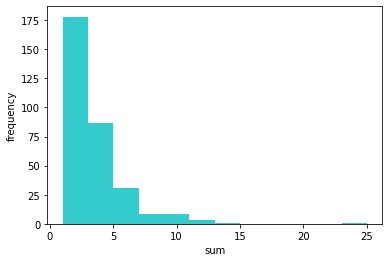

In [33]:
#疾患・症状のTFIDFがゼロより大きい値を取り出した時の可視化

#plt.figure(figsize=(12,4))

#TFIDFの数
each_disease_sum_vector = [sum(pivot_tfidf_df.loc[disease, :]>0) for disease in pivot_tfidf_df.index]
plt.hist(each_disease_sum_vector,color='c', bins=len(set(each_disease_sum_vector)), alpha=0.8)
plt.xlabel('sum')
plt.ylabel("frequency")
plt.show()

In [34]:
#コサイン類似度　計算

#コサイン算出用データフレームを作る
pre_cosine_df = tfidf.sort_values(['symptom', 'disease'])[['symptom', 'disease',"tf_idf"]].reset_index(drop=True)
pre_cosine_df = pd.pivot_table(pre_cosine_df, index='disease', columns='symptom', values="tf_idf")
pre_cosine_df = pre_cosine_df.fillna(0)#欠損値に0を入れる
#疾患個数
print(len(pre_cosine_df.index)) 


317


In [35]:
#疾患ペア(直積ペア)を作る
import itertools
product_list = list(itertools.product(pre_cosine_df.index, pre_cosine_df.index))
print(len(product_list))#2047761
print(product_list[0], product_list[1])

100489
('MESH:D000080984', 'MESH:D000080984') ('MESH:D000080984', 'MESH:D000081003')


In [36]:
#tfidf行列を疾患（＝行）ごとに分けて直積ペアを作る
vectors = [each_vectors for each_vectors in np.array(pre_cosine_df)]
vectors_list = list(itertools.product(vectors, vectors))

In [37]:
#コサイン類似度

#計算式
def cosine_similarity(x, y):#xとyはベクトルの成分
    return (np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))))

#直積ペアにコサイン類似度計算を適用 
cosine_similarity_list = []
for disease_pair, vector in tqdm(zip( product_list, vectors_list )):
    cosine_similarity_list.append([disease_pair[0], disease_pair[-1], cosine_similarity(vector[0], vector[1])])

0it [00:00, ?it/s]

In [38]:
#データフレーム化
cosine_df = pd.DataFrame(cosine_similarity_list, columns=["disease_1", "disease_2", "cosine_similarity"])
cosine_df = cosine_df.sort_values("cosine_similarity", ascending=False).reset_index(drop=True)
pivot_cosine_df = cosine_df.pivot(index='disease_1', columns='disease_2', values='cosine_similarity')#.fillna(0)
print(len(cosine_df), len(pivot_cosine_df))
#2047761 1431

100489 317


In [39]:
#インデックスを取得
pivot_index = pivot_cosine_df.index.tolist()

In [40]:
#「同じ疾患同士」「順序が逆になっているだけで同じペアの片方」を削除

#アレイに変換
recent_array = np.array(pivot_cosine_df)

#下三角行列を取得する
#numpy.tril()の引数にnumpy.ndarrayを指定すると、対角線より上の成分をゼロとしたnumpy.ndarrayが返される。
#対角線のコサイン値＝１は不要なので、この対角線箇所も含めてゼロにしたい。
#numpy.tril()の第二引数のkで、境界となる対角線の位置が指定できる（正の値だと上側（右側）、負の値だと下側（左側）に移動する）

recent_array = np.tril(recent_array, k=-1) 

#データフレームにする　対角線含む上の値がゼロになっているか確認
repivot_cosine_df= pd.DataFrame(recent_array, index=pivot_cosine_df.index, columns=pivot_cosine_df.columns)


In [41]:
repivot_cosine_df[:5]

disease_2,MESH:D000080984,MESH:D000081003,MESH:D000083143,MESH:D000130,MESH:D000141,MESH:D000326,MESH:D000361,MESH:D000474,MESH:D000742,MESH:D000755,...,MESH:D057826,MESH:D058247,MESH:D058494,MESH:D058495,MESH:D058496,MESH:D058540,MESH:D065627,MESH:D065635,MESH:D065708,MESH:D065766
disease_1,,,,,,,,,,,,,,,,,,,,,
MESH:D000080984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MESH:D000081003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MESH:D000083143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MESH:D000130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MESH:D000141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
#下三角行列のうち、コサイン値ゼロ以外の値の位置を取得
recent_array_index_list = [[value_0,
                            value_1] for value_0, value_1 in zip(list(np.where(recent_array>0)[0]),
                                                                 list(np.where(recent_array>0)[1]))]
print(len(recent_array_index_list))

9763


In [43]:
#元の（半分ゼロにする前の）行列で同じ位置を指定し、そのインデックス（疾患ペア）と値（コサイン値）を取得
#疾患a, 疾患b, abのコサイン値
repivot_pair = [ [pivot_index[i[0]],
                  pivot_index[i[1]], 
                  repivot_cosine_df.iloc[i[0], i[1]]] for i in tqdm(recent_array_index_list)]

# 作成されるデータは
#    「同じ疾患同士」「順序が逆になっただけの同じペアのうちの片方」「コサイン値ゼロ」これらを除いたデータ

  0%|          | 0/9763 [00:00<?, ?it/s]

In [44]:
hpo = pd.DataFrame(repivot_pair, columns=["disease_1", "disease_2", "cosine_similarity"])

In [45]:
hpo[:3]

,disease_1,disease_2,cosine_similarity
0,MESH:D000326,MESH:D000130,0.045566
1,MESH:D000755,MESH:D000742,0.726524
2,MESH:D000795,MESH:D000130,0.031456


In [46]:
print("疾患・症状ペアの数:", len(tfidf))
print("disease_MeSH:", len(repivot_cosine_df.index))
print("symptom_MeSH:", len(idf_n_i), "\n")

疾患・症状ペアの数: 930
disease_MeSH: 317
symptom_MeSH: 137 



In [47]:
print("疾患・疾患ペアの数:", len(hpo))
print("cos>0.1の時:", len(hpo[hpo["cosine_similarity"]>0.1]))
print("cos>0.2の時:", len(hpo[hpo["cosine_similarity"]>0.2]))
print("cos>0.5の時:", len(hpo[hpo["cosine_similarity"]>0.5]), "\n")

疾患・疾患ペアの数: 9763
cos>0.1の時: 6485
cos>0.2の時: 4166
cos>0.5の時: 1023 



In [48]:
print("---cos>0.1---")
cos_a = hpo[hpo["cosine_similarity"]>0.1]
print("疾患・疾患ペアの数:", len(cos_a))
print("disaease_MeSH:", len(set(cos_a["disease_1"].values.tolist() + cos_a["disease_2"].values.tolist())))
print("max_cos:", cos_a["cosine_similarity"].max())
print("min_cos:", cos_a["cosine_similarity"].min(), "\n")

---cos>0.1---
疾患・疾患ペアの数: 6485
disaease_MeSH: 310
max_cos: 1.0000000000000002
min_cos: 0.10003853747163853 



In [49]:
print("---cos>0.1, cos<1---")
cos_b = hpo[ (hpo["cosine_similarity"]>0.1) & (hpo["cosine_similarity"]<1)]
print("疾患・疾患ペアの数:", len(cos_b))
print("disaease_MeSH:", len(set(cos_b["disease_1"].values.tolist() + cos_b["disease_2"].values.tolist())))
print("max_cos:", cos_b["cosine_similarity"].max())
print("min_cos:", cos_b["cosine_similarity"].min(), "\n")

---cos>0.1, cos<1---
疾患・疾患ペアの数: 6219
disaease_MeSH: 305
max_cos: 0.9999999999999999
min_cos: 0.10003853747163853 



In [50]:
#hpo_cos MeSH 列名修正

hpo["disease_1_id"] = [i.replace("MESH:", '') for i in hpo["disease_1"] ] 
hpo["disease_2_id"] = [i.replace("MESH:", '') for i in hpo["disease_2"] ] 
hpo = hpo[["disease_1_id", "disease_2_id", 'cosine_similarity'] ]
hpo.set_axis(['disease_1', 'disease_2', 'cosine_similarity'], axis='columns', inplace=True)


In [51]:
hpo[:3]

,disease_1,disease_2,cosine_similarity
0,D000326,D000130,0.045566
1,D000755,D000742,0.726524
2,D000795,D000130,0.031456


In [58]:
os.chdir("../folder_05")
hpo.to_csv("hpo.csv", index=False)